# First things first

The National Agency of Petroleum, Natural Gas and Bio fuels (ANP in Portuguese) releases weekly reports of gas, diesel and other fuels prices used in transportation across the country. 

**Question**
How much will be the Diesel price in the next week?

https://www.kaggle.com/matheusfreitag/gas-prices-in-brazil/data

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
data = pd.read_csv('2004-2019.tsv', sep = '\t', index_col = 0)
data.sample(3) # Let's take a look

,DATA INICIAL,DATA FINAL,REGIÃO,ESTADO,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO,MÊS,ANO
5980,2008-08-17,2008-08-23,NORTE,RORAIMA,ETANOL HIDRATADO,13,R$/l,2.169,0.038,2.150,2.250,0.333,0.018,1.836,0.079,1.7171,1.8825,0.043,8,2008
106130,2019-05-26,2019-06-01,NORDESTE,ALAGOAS,ÓLEO DIESEL S10,44,R$/l,3.836,0.178,3.699,4.500,0.387,0.046,3.449,0.077,3.37,3.5969,0.022,5,2019
100132,2018-08-19,2018-08-25,CENTRO OESTE,DISTRITO FEDERAL,ÓLEO DIESEL S10,31,R$/l,3.574,0.103,3.199,3.759,0.303,0.029,3.271,0.056,3.195,3.37,0.017,8,2018


## Diesel prices modeling

In [3]:
diesel = data[data.PRODUTO == 'ÓLEO DIESEL'].copy()

formating date columns (weekly instances from data.info())

In [4]:
diesel['DATA INICIAL'] = pd.to_datetime(diesel['DATA INICIAL']) # Date columns are str instead of DateTime
diesel['DATA FINAL'] = pd.to_datetime(diesel['DATA FINAL']) # Date columns are str instead of DateTime

Dataset splits

In [5]:
diesel_train = diesel[diesel['DATA FINAL'] < '2011-05-15'] # 7 years 
diesel_val   = diesel[(diesel['DATA FINAL'] >= '2011-05-15') & (diesel['DATA FINAL'] < '2018-01-01')] # 7 years
diesel_test  = diesel[diesel['DATA FINAL'] >= '2018-05-15'] # 1 year
diesel_train.shape, diesel_val.shape, diesel_test.shape 

((9773, 20), (9315, 20), (1593, 20))

**Target definition**

In [6]:
y_train = diesel_train['PREÇO MÉDIO REVENDA']
y_val   = diesel_val['PREÇO MÉDIO REVENDA']
y_test  = diesel_test['PREÇO MÉDIO REVENDA']

Mini exploration

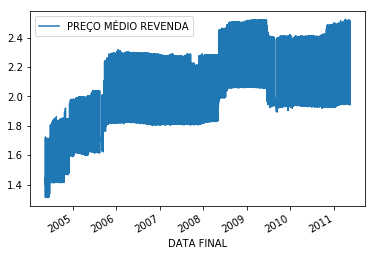

In [7]:
diesel_train.plot(x = 'DATA FINAL', y = 'PREÇO MÉDIO REVENDA') # The target is not stationary!!!! 

After seeing both variance and mean changing through time, let's created the variable current_price - future_price and examine its plot

In [8]:
def target_diff(x):
    """ Compute the difference between two consecutives rows in a serie """
    x = x.diff() # First discrete difference for a Serie
    x = x.shift(-1) # shifting its result at the same level (leaving last element as nan)
    return x

In [9]:
diesel_train['DIFF'] = diesel_train.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].apply(target_diff)
diesel_val['DIFF']   = diesel_val.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].apply(target_diff)
diesel_test['DIFF']  = diesel_test.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].apply(target_diff)

C:\Users\vipac\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\vipac\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\vipac\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

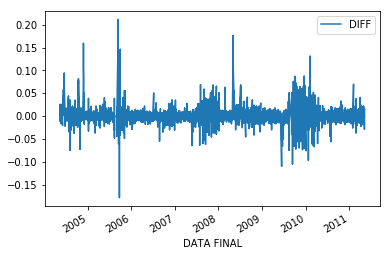

In [10]:
diesel_train.plot(x = 'DATA FINAL', y = 'DIFF') # these behaviors are better for Time Series

## Selecting features V2

Let's create a new dataframe with features used to modeling

In [11]:
df_X_train = pd.DataFrame(index = diesel_train.index)
df_X_val   = pd.DataFrame(index = diesel_val.index)
df_X_test  = pd.DataFrame(index = diesel_test.index)

**Train set**

In [12]:
######## SEASONAL ########
df_X_train['DAY'] = diesel_train['DATA FINAL'].dt.day
df_X_train['MONTH'] = diesel_train['DATA FINAL'].dt.month
df_X_train['DAY_of_YEAR'] = diesel_train['DATA FINAL'].dt.dayofyear
df_X_train['WEEK_of_YEAR'] = diesel_train['DATA FINAL'].dt.weekofyear

######## LAG (Rezago :P ) ########
for i in range(0,12): # 12 new features with lags from 11 weeks ago
    df_X_train['LAG_{0}'.format(i)] = diesel_train['PREÇO MÉDIO REVENDA'].shift(i) 
for i in range(1,12): # 11 new features with lags between current and until 11 weeks ago
    df_X_train['DIFF_LAG_{0}'.format(i)] = diesel_train.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].diff(i) 

######## MA (moving average) ########
for i in range(2,12): # 9 new features with a moving average calculated from 2 until 11 weeks of rolling
    df_X_train['MA_{0}'.format(i)] = diesel_train.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].rolling(i).mean().reset_index(level = 0, drop = True)

######## From dataset ########
df_X_train['DIFF'] = diesel_train['DIFF']

######## Categorical ########
from category_encoders import OneHotEncoder
OneHotEnconder = OneHotEncoder(cols = ['STATE', 'ZONE'], use_cat_names = True, drop_invariant = True) #dropping columns with 0 variance
df_X_train['STATE'] = diesel_train['ESTADO']
df_X_train['ZONE'] = diesel_train['REGIÃO']
df_X_train = OneHotEnconder.fit_transform(df_X_train) # one hot encoder for Estado and Regiao 

######## The own time series for each state ########
df_X_train['DATA FINAL'] = diesel_train['DATA FINAL']
df_X_train['STATE'] = diesel_train['ESTADO']

df_pivot = df_X_train.pivot(index = 'DATA FINAL', columns = 'STATE', values = 'DIFF_LAG_1')
df_pivot.columns += '_DIFF_LAG_1'
df_X_train = pd.merge(df_X_train, df_pivot, on = 'DATA FINAL', how = 'left')

######## Ranking ########
df_X_train['RANKING'] = df_X_train.groupby('DATA FINAL')['DIFF_LAG_1'].rank()

######## DROPPING NAN ########
df_X_train = df_X_train.dropna()

######## x_train, y_train ########
X_train = df_X_train.drop(['DIFF', 'STATE', 'DATA FINAL'], axis = 1)
y_train = df_X_train['DIFF']

In [13]:
df_X_train.shape, X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9423 entries, 297 to 9745
Data columns (total 97 columns):
DAY                               9423 non-null int64
MONTH                             9423 non-null int64
DAY_of_YEAR                       9423 non-null int64
WEEK_of_YEAR                      9423 non-null int64
LAG_0                             9423 non-null float64
LAG_1                             9423 non-null float64
LAG_2                             9423 non-null float64
LAG_3                             9423 non-null float64
LAG_4                             9423 non-null float64
LAG_5                             9423 non-null float64
LAG_6                             9423 non-null float64
LAG_7                             9423 non-null float64
LAG_8                             9423 non-null float64
LAG_9                             9423 non-null float64
LAG_10                            9423 non-null float64
LAG_11                            9423 non-null float64
DIF

((9423, 100), None)

In [14]:
X_train.describe()

,DAY,MONTH,DAY_of_YEAR,WEEK_of_YEAR,LAG_0,LAG_1,LAG_2,LAG_3,LAG_4,LAG_5,...,RIO DE JANEIRO_DIFF_LAG_1,RIO GRANDE DO NORTE_DIFF_LAG_1,RIO GRANDE DO SUL_DIFF_LAG_1,RONDONIA_DIFF_LAG_1,RORAIMA_DIFF_LAG_1,SANTA CATARINA_DIFF_LAG_1,SAO PAULO_DIFF_LAG_1,SERGIPE_DIFF_LAG_1,TOCANTINS_DIFF_LAG_1,RANKING
count,9423.000000,9423.000000,9423.000000,9423.000000,9423.000000,9423.000000,9423.000000,9423.000000,9423.000000,9423.000000,...,9423.000000,9423.000000,9423.000000,9423.000000,9423.000000,9423.000000,9423.000000,9423.000000,9423.000000,9423.000000
mean,15.659026,6.495702,182.226361,26.595989,1.961861,1.961804,1.961748,1.961697,1.961642,1.961584,...,0.001564,0.001622,0.001490,0.001410,0.001954,0.001553,0.001464,0.001688,0.001298,14.000000
std,8.805002,3.519777,107.504130,15.402975,0.199176,0.199229,0.199265,0.199326,0.199388,0.199453,...,0.014223,0.018493,0.016373,0.018034,0.017678,0.014054,0.014947,0.019442,0.019303,7.758644
min,1.000000,1.000000,1.000000,1.000000,1.415000,1.415000,1.415000,1.415000,1.415000,1.415000,...,-0.042000,-0.078000,-0.072000,-0.096000,-0.054000,-0.052000,-0.046000,-0.055000,-0.087000,1.000000
25%,8.000000,3.000000,87.000000,13.000000,1.848000,1.848000,1.848000,1.848000,1.848000,1.848000,...,-0.002000,-0.003000,-0.002000,-0.004000,-0.002000,-0.002000,-0.001000,-0.005000,-0.003000,7.500000
50%,16.000000,7.000000,182.000000,27.000000,1.966000,1.966000,1.966000,1.966000,1.966000,1.966000,...,0.001000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000
75%,23.000000,10.000000,276.000000,40.000000,2.080000,2.080000,2.080000,2.080000,2.080000,2.080000,...,0.003000,0.003000,0.002000,0.005000,0.002000,0.003000,0.001000,0.006000,0.004000,20.500000
max,31.000000,12.000000,365.000000,53.000000,2.523000,2.523000,2.523000,2.523000,2.523000,2.523000,...,0.159000,0.204000,0.173000,0.168000,0.171000,0.160000,0.175000,0.194000,0.200000,27.000000


**Val set**

In [15]:
######## SEASONAL ########
df_X_val['DAY'] = diesel_val['DATA FINAL'].dt.day
df_X_val['MONTH'] = diesel_val['DATA FINAL'].dt.month
df_X_val['DAY_of_YEAR'] = diesel_val['DATA FINAL'].dt.dayofyear
df_X_val['WEEK_of_YEAR'] = diesel_val['DATA FINAL'].dt.weekofyear

######## LAG (Rezago :P ) ########
for i in range(0,12): # 12 new features with lags from 11 weeks ago
    df_X_val['LAG_{0}'.format(i)] = diesel_val['PREÇO MÉDIO REVENDA'].shift(i) 
for i in range(1,12): # 11 new features with lags between current and until 11 weeks ago
    df_X_val['DIFF_LAG_{0}'.format(i)] = diesel_val.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].diff(i) 

######## MA (moving average) ########
for i in range(2,12): # 9 new features with a moving average calculated from 2 until 11 weeks of rolling
    df_X_val['MA_{0}'.format(i)] = diesel_val.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].rolling(i).mean().reset_index(level = 0, drop = True)

######## From dataset ########
df_X_val['DIFF'] = diesel_val['DIFF']

######## Categorical ########
df_X_val['STATE'] = diesel_val['ESTADO']
df_X_val['ZONE'] = diesel_val['REGIÃO']
df_X_val = OneHotEnconder.transform(df_X_val) # one hot encoder for Estado and Regiao 

######## The own time series for each state ########
df_X_val['DATA FINAL'] = diesel_val['DATA FINAL']
df_X_val['STATE'] = diesel_val['ESTADO']

df_pivot = df_X_val.pivot(index = 'DATA FINAL', columns = 'STATE', values = 'DIFF_LAG_1')
df_pivot.columns += '_DIFF_LAG_1'
df_X_val = pd.merge(df_X_val, df_pivot, on = 'DATA FINAL', how = 'left')

######## Ranking ########
df_X_val['RANKING'] = df_X_val.groupby('DATA FINAL')['DIFF_LAG_1'].rank()

######## DROPPING NAN ########
df_X_val = df_X_val.dropna()

######## x_val, y_val ########
X_val = df_X_val.drop(['DIFF', 'STATE', 'DATA FINAL'], axis = 1)
y_val = df_X_val['DIFF']

**Test set**

In [16]:
######## SEASONAL ########
df_X_test['DAY'] = diesel_test['DATA FINAL'].dt.day
df_X_test['MONTH'] = diesel_test['DATA FINAL'].dt.month
df_X_test['DAY_of_YEAR'] = diesel_test['DATA FINAL'].dt.dayofyear
df_X_test['WEEK_of_YEAR'] = diesel_test['DATA FINAL'].dt.weekofyear

######## LAG (Rezago :P ) ########
for i in range(0,12): # 12 new features with lags from 11 weeks ago
    df_X_test['LAG_{0}'.format(i)] = diesel_test['PREÇO MÉDIO REVENDA'].shift(i) 
for i in range(1,12): # 11 new features with lags between current and until 11 weeks ago
    df_X_test['DIFF_LAG_{0}'.format(i)] = diesel_test.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].diff(i) 

######## MA (moving average) ########
for i in range(2,12): # 9 new features with a moving average calculated from 2 until 11 weeks of rolling
    df_X_test['MA_{0}'.format(i)] = diesel_test.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].rolling(i).mean().reset_index(level = 0, drop = True)

######## From dataset ########
df_X_test['DIFF'] = diesel_test['DIFF']

######## Categorical ########
df_X_test['STATE'] = diesel_test['ESTADO']
df_X_test['ZONE'] = diesel_test['REGIÃO']
df_X_test = OneHotEnconder.transform(df_X_test) # one hot encoder for Estado and Regiao 

######## The own time series for each state ########
df_X_test['DATA FINAL'] = diesel_test['DATA FINAL']
df_X_test['STATE'] = diesel_test['ESTADO']

df_pivot = df_X_test.pivot(index = 'DATA FINAL', columns = 'STATE', values = 'DIFF_LAG_1')
df_pivot.columns += '_DIFF_LAG_1'
df_X_test = pd.merge(df_X_test, df_pivot, on = 'DATA FINAL', how = 'left')

######## Ranking ########
df_X_test['RANKING'] = df_X_test.groupby('DATA FINAL')['DIFF_LAG_1'].rank()

######## DROPPING NAN ########
df_X_test = df_X_test.dropna()

######## x_val, y_val ########
X_test = df_X_test.drop(['DIFF', 'STATE', 'DATA FINAL'], axis = 1)
y_test = df_X_test['DIFF']

## Model

### Random Forest Regressor

In [17]:
from sklearn.ensemble import RandomForestRegressor

In [55]:
clf = RandomForestRegressor(n_estimators = 1000, random_state = 21, min_samples_leaf = 128)
clf.fit(X_train,y_train)
preds = clf.predict(X_val)

In [56]:
from sklearn.metrics import mean_squared_log_error

error = np.sqrt(mean_squared_log_error(
    X_val['LAG_0'] + y_val, X_val['LAG_0'] + preds)) # Root mean squared logarithmic error 
print('error:', error*100)

error: 0.6538665888205328


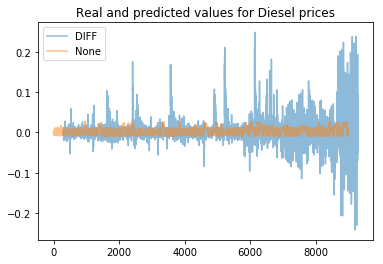

In [57]:
y_val.plot(kind = 'line',alpha = 0.5, legend = True)
pd.Series(preds).plot(kind = 'line', alpha = 0.5, legend = True, title = 'Real and predicted values for Diesel prices')

### LightGBM

In [62]:
from lightgbm import LGBMRegressor as lgbm

In [74]:
clf = lgbm(random_state = 21, n_estimators = 100, learning_rate = 0.001, num_leaves = 2**6, subsamples = 0.9 )
clf.fit(X_train,y_train)
preds = clf.predict(X_val)

In [75]:
error = np.sqrt(mean_squared_log_error(
    X_val['LAG_0'] + y_val, X_val['LAG_0'] + preds)) # Root mean squared logarithmic error 
print('error:', error*100)

error: 0.6619530835526289


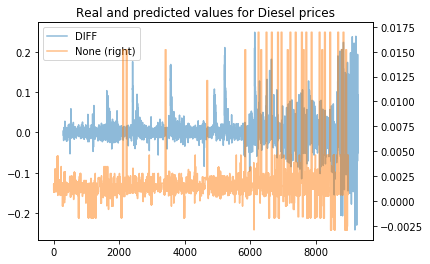

In [76]:
y_val.plot(kind = 'line',alpha = 0.5, legend = True)
pd.Series(preds).plot(kind = 'line', alpha = 0.5, legend = True, title = 'Real and predicted values for Diesel prices' , secondary_y = True)

LightGBM is quicker and more accurate in fitting variances along the time!

## Feature selection

In [104]:
features_list = []
accepted_error = 1000
for feature in X_train.columns:
    clf = lgbm(random_state = 21, n_estimators = 100, learning_rate = 0.001, num_leaves = 2**6, subsamples = 0.9 )
    clf.fit(X_train[[feature]], y_train)
    preds = clf.predict(X_val[[feature]])
    
    error = np.sqrt(mean_squared_log_error(X_val['LAG_0'] + y_val, X_val['LAG_0'] + preds))*100
    if error <= accepted_error:
        features_list.append(feature)
        accepted_error = error
        
        print('feature:', feature, '-> error:',round(error, 4))               

feature: DAY -> error: 0.668
feature: MONTH -> error: 0.6678
feature: WEEK_of_YEAR -> error: 0.6677
feature: DIFF_LAG_1 -> error: 0.6666
feature: MINAS GERAIS_DIFF_LAG_1 -> error: 0.6663
feature: PARAIBA_DIFF_LAG_1 -> error: 0.6648


In [105]:
clf = lgbm(random_state = 21, n_estimators = 100, learning_rate = 0.001, num_leaves = 2**6, subsamples = 0.9 )
clf.fit(X_train[features_list],y_train)
preds = clf.predict(X_val[features_list])

In [106]:
error = np.sqrt(mean_squared_log_error(
    X_val['LAG_0'] + y_val, X_val['LAG_0'] + preds)) # Root mean squared logarithmic error 
print('error:', error*100)

error: 0.6586808111102694


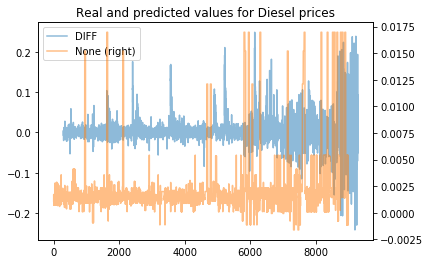

In [107]:
y_val.plot(kind = 'line',alpha = .5, legend = True)
pd.Series(preds).plot(kind = 'line', alpha = .5, legend = True, title = 'Real and predicted values for Diesel prices' , secondary_y = True)

In [109]:
from sklearn.model_selection import RandomizedSearchCV

## Selecting features V1

Let's create a new dataframe with features used to modeling

In [90]:
df_X_train = pd.DataFrame(index = diesel_train.index)
df_X_val   = pd.DataFrame(index = diesel_val.index)
df_X_test  = pd.DataFrame(index = diesel_test.index)

**train set**

In [91]:
######## SEASONAL ########
df_X_train['DAY'] = diesel_train['DATA FINAL'].dt.day
df_X_train['MONTH'] = diesel_train['DATA FINAL'].dt.month
df_X_train['DAY_of_YEAR'] = diesel_train['DATA FINAL'].dt.dayofyear

######## LAG (Rezago :P ) ########
df_X_train['LAG'] = diesel_train['PREÇO MÉDIO REVENDA']
df_X_train['DIFF_LAG'] = diesel_train.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].diff()

######## MA (moving average) ########
df_X_train['MA'] = diesel_train.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].rolling(4).mean().reset_index(level = 0, drop = True)

################
df_X_train['DIFF'] = diesel_train['DIFF']
df_X_train = df_X_train.dropna()

X_train = df_X_train.drop(['DIFF'], axis = 1)
y_train = df_X_train['DIFF']

In [93]:
X_train.describe()

,DAY,MONTH,DAY_of_YEAR,LAG,DIFF_LAG,MA
count,9665.000000,9665.000000,9665.000000,9665.000000,9665.000000,9665.000000
mean,15.612519,6.505225,182.475841,1.951631,0.001822,1.948900
std,8.784286,3.480967,106.299947,0.208517,0.017622,0.210385
min,1.000000,1.000000,1.000000,1.313000,-0.177000,1.314000
25%,8.000000,3.000000,90.000000,1.841000,-0.002000,1.839250
50%,16.000000,7.000000,182.000000,1.959000,0.000000,1.957000
75%,23.000000,10.000000,276.000000,2.078000,0.003000,2.077000
max,31.000000,12.000000,365.000000,2.523000,0.211000,2.520500


**val set**

In [94]:
####### SEASONAL ########
df_X_val['DAY'] = diesel_val['DATA FINAL'].dt.day
df_X_val['MONTH'] = diesel_val['DATA FINAL'].dt.month
df_X_val['DAY_of_YEAR'] = diesel_val['DATA FINAL'].dt.dayofyear

######## LAG (Rezago :P ) ########
df_X_val['LAG'] = diesel_val['PREÇO MÉDIO REVENDA']
df_X_val['DIFF_LAG'] = diesel_val.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].diff()

######## MA (moving average) ########
df_X_val['MA'] = diesel_val.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].rolling(4).mean().reset_index(level = 0, drop = True)

################
df_X_val['DIFF'] = diesel_val['DIFF']
df_X_val = df_X_val.dropna()

X_val = df_X_val.drop(['DIFF'], axis = 1)
y_val = df_X_val['DIFF']

**test set**

In [95]:
######## SEASONAL ########
df_X_test['DAY'] = diesel_test['DATA FINAL'].dt.day
df_X_test['MONTH'] = diesel_test['DATA FINAL'].dt.month
df_X_test['DAY_of_YEAR'] = diesel_test['DATA FINAL'].dt.dayofyear

######## LAG (Rezago :P ) ########
df_X_test['LAG'] = diesel_test['PREÇO MÉDIO REVENDA']
df_X_test['DIFF_LAG'] = diesel_test.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].diff()

######## MA (moving average) ########
df_X_test['MA'] = diesel_test.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].rolling(4).mean().reset_index(level = 0, drop = True)

################
df_X_test['DIFF'] = diesel_test['DIFF']
df_X_test = df_X_test.dropna()

X_test = df_X_test.drop(['DIFF'], axis = 1)
y_test = df_X_test['DIFF']

## Model

In [96]:
from sklearn.ensemble import RandomForestRegressor

In [97]:
clf = RandomForestRegressor(n_estimators = 500, random_state = 21)
clf.fit(X_train,y_train)
preds = clf.predict(X_val)

In [98]:
from sklearn.metrics import mean_squared_log_error

error = np.sqrt(mean_squared_log_error(
    X_val['LAG'] + y_val, X_val['LAG'] + preds)) # Root mean squared logarithmic error 
print('error:', error*100)

error: 0.6855239815574414


## Feature selection

In [19]:
for feature in X_train.columns:
    clf = RandomForestRegressor(n_estimators = 500, random_state = 21)
    clf.fit(X_train[[feature]], y_train)
    preds = clf.predict(X_val[[feature]])
    
    error = np.sqrt(mean_squared_log_error(X_val['LAG'] + y_val, X_val['LAG'] + preds))*100
    print('feature:', feature, '-> error:',round(error, 4))

feature: DAY -> error: 0.6706
feature: MONTH -> error: 0.6621
feature: DAY_of_YEAR -> error: 0.7716
feature: LAG -> error: 0.7493
feature: DIFF_LAG -> error: 0.6654
feature: MA -> error: 0.6952
